In [13]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [14]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [3]:
# Test environment with random actions
done = True
env.reset()
# Render env with random actions, 5 times
for i in range(5):
    # Go through episode
    for j in range(5000):
        env.render() 
        # Random action
        observation, reward, done, info = env.step(env.action_space.sample())
        if done: 
            # Start the game
            env.reset()
# Close the game
env.close()

C:\Users\soner\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
C:\Users\soner\AppData\Local\Programs\Python\Python310\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [15]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [25]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# # 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [26]:
state = env.reset()

In [33]:
state, reward, done, info = env.step([5])

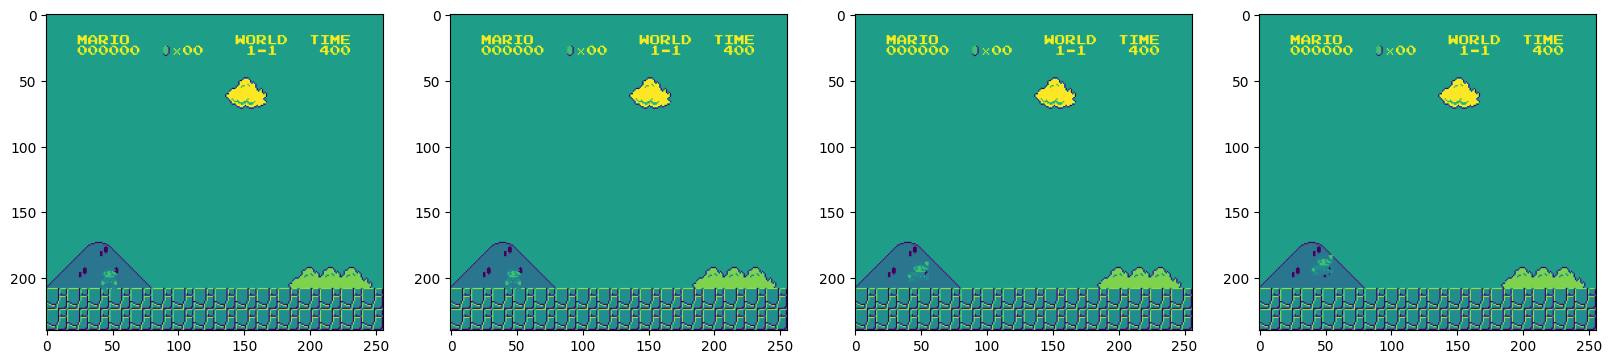

In [34]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [35]:
print(state.shape)

(1, 240, 256, 4)


In [36]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
import time
from time import sleep


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [37]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [57]:
class DQN(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Conv2d(n_frame, 32, 8, 4)
        self.layer2 = nn.Conv2d(32, 64, 3, 1)
        self.fc = nn.Linear(20736, 512)
        self.q = nn.Linear(512, n_action)
        self.v = nn.Linear(512, 1)
        self.seq = nn.Sequential(self.layer1, self.layer2, self.fc, self.q, self.v)

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x).to(self.device)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = x.view(-1, 20736)
        x = torch.relu(self.fc(x))
        adv = self.q(x)
        v = self.v(x)
        q = v + (adv - 1 / adv.shape[-1] * adv.max(-1, True)[0])

        return q

In [45]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)
print(n_actions)


def select_action(state,policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        #display.clear_output(wait=True)
        display.display(plt.gcf())

7


In [46]:
def optimize_model(memory,policy_net,target_net,optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [47]:
def train_model(num_episodes,memory,policy_net,target_net,optimizer,isRandom=False):
    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        state = env.reset()
        state = torch.tensor(state,device=device).unsqueeze(0)
        for t in count():
            if isRandom  == True:
              action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
            else:
              action = select_action(state,policy_net)
            observation, reward, terminated, info = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated

            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model(memory,policy_net,target_net,optimizer)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                break
    print('Complete')
    

In [48]:
def simulate_games(policy_net,memory,video,isRandom=False):
# Each of these is its own game.
    for episode in range(5):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            env.render()
            video.capture_frame()
            if isRandom == True:
              action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
            else:
              action = select_action(state,policy_net)
            observation, reward, terminated,info = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            if done:
                break
    
    video.close()
    env.close()

In [59]:
n_actions = env.action_space.n
input_size = state.shape[1] * state.shape[2]

policy_net600 = DQN(input_size,n_actions).to(device)
target_net600 = DQN(input_size,n_actions).to(device)
target_net600.load_state_dict(policy_net600.state_dict())

optimizer600 = optim.AdamW(policy_net600.parameters(), lr=LR, amsgrad=True)
memory_train600 = ReplayMemory(100_000)
episode_durations = []
steps_done = 0


train_model(num_episodes=600,memory=memory_train600,policy_net=policy_net600,target_net=target_net600,optimizer=optimizer600)
plot_durations()
plt.ioff()
plt.show()


NameError: name 'n_frame' is not defined